## *Hmong Opium Package*

![](PXL_20240613_105950267.jpg){ fig-align="center" width="60%"}

In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_site(nodes, site_name):
    if isinstance(nodes[site_name], torch.Tensor):
        value = nodes[site_name].flatten().detach().numpy()
    else:
        value = nodes[site_name]["value"].flatten().detach().numpy()

    mean_of_value = np.nanmean(value)

    plt.hist(value, bins=50)
    plt.title(f"{site_name}, mean: {mean_of_value}")
    plt.xlim(0, 1)
    plt.xlabel("value")
    plt.ylabel("frequency")
    sns.despine()
    plt.show()

In [3]:
def normalize_posterior(posterior: torch.Tensor, k: int = 1000) -> torch.Tensor:

    hist = torch.histc(posterior, bins=k)
    return hist / hist.sum()


def weight(posterior: List[float], base=2, k=1000) -> float:

    posterior = normalize_posterior(posterior, k)

    grid_length = k
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(
        x, 1, 1
    )  # def. of a uniform distribution given the size of the posterior

    entropy_uniform = entropy(uniform, base=base)  # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base)  # entropy H(p)
    return 1 - entropy_posterior / entropy_uniform  # weight = 1 - H(p)/H(uniform)

In [4]:
def hmong_core(
    pr_Hmong,
    pr_Hmong_if_smuggler,
    pr_smuggler,
    pr_package_if_smuggler,
    pr_package_if_not_smuggler,
):

    with pyro.plate("hmong_core_estimation", size=1e4):
        is_smuggler = pyro.sample("is_smuggler", dist.Bernoulli(pr_smuggler))

        pr_Hmong_given_smuggler = (
            is_smuggler * pr_Hmong_if_smuggler + (1 - is_smuggler) * pr_Hmong
        )

        is_hmong = pyro.sample("is_hmong", dist.Bernoulli(pr_Hmong_given_smuggler))

        actual_pr_package = (
            is_smuggler * pr_package_if_smuggler
            + (1 - is_smuggler) * pr_package_if_not_smuggler
        )

        has_package = pyro.sample("has_package", dist.Bernoulli(actual_pr_package))

    evidence_mask = is_hmong * has_package

    evidence_mask_not_hmong = (1 - is_hmong) * has_package

    filtered_is_smuggler = torch.where(
        evidence_mask == 1, is_smuggler, torch.tensor(float("nan"))
    )

    filtered_is_smuggler_not_hmong = torch.where(
        evidence_mask_not_hmong == 1, is_smuggler, torch.tensor(float("nan"))
    )

    posterior_is_smuggler = torch.nanmean(filtered_is_smuggler, axis=0)

    posterior_is_smuggler_not_hmong = torch.nanmean(
        filtered_is_smuggler_not_hmong, axis=0
    )

    return [posterior_is_smuggler, posterior_is_smuggler_not_hmong]


with pyro.plate("samples", size=5):
    posterior = hmong_core(0.06, 0.95, 0.5, 0.9, 0.1)

print(posterior)

[tensor([0.9935, 0.9940, 0.9927, 0.9954, 0.9934]), tensor([0.3165, 0.3115, 0.3534, 0.3493, 0.3361])]


In [9]:
prior_smuggler = .02
pr_Hmong = 0.06
pr_Hmong_if_smuggler = 0.95

pr_smuggler_if_Hmong =  (pr_Hmong_if_smuggler * prior_smuggler)/((pr_Hmong_if_smuggler * prior_smuggler) + (pr_Hmong * 1-prior_smuggler))

print(pr_smuggler_if_Hmong)

0.3220338983050848


In [5]:
def hmong_bayesian():

    pr_Hmong = 0.06
    pr_Hmong_if_smuggler = 0.95

    pr_smuggler = pyro.sample(
        "pr_smuggler", dist.Beta(2, 48)
    )  # unlikely to be a smuggler

    pr_package_if_smuggler = pyro.sample(
        "pr_package_if_smuggler", dist.Beta(20, 2)
    )  # likely to have a package if smuggler
    pr_package = pyro.sample(
        "pr_package", dist.Beta(2, 10)
    )  # unlikely to have a package

    estimates = hmong_core(
        pr_Hmong, pr_Hmong_if_smuggler, pr_smuggler, pr_package_if_smuggler, pr_package
    )

    pyro.deterministic("posterior_smuggler_if_Hmong", estimates[0], event_dim=0)

    pyro.deterministic("posterior_smuggler_not_Hmong", estimates[1], event_dim=0)


with pyro.plate("samples", 1000):
    with pyro.poutine.trace() as tr:
        hmong_bayesian()

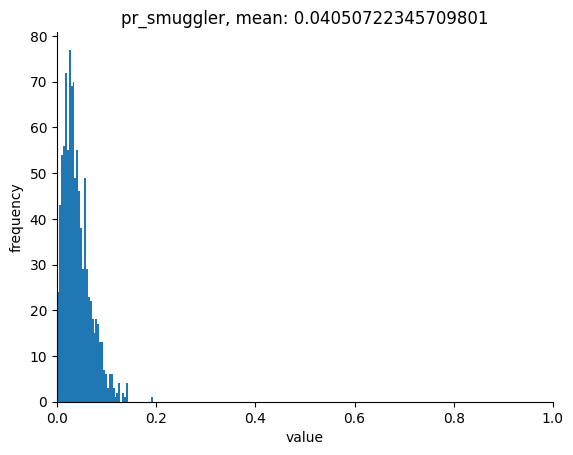

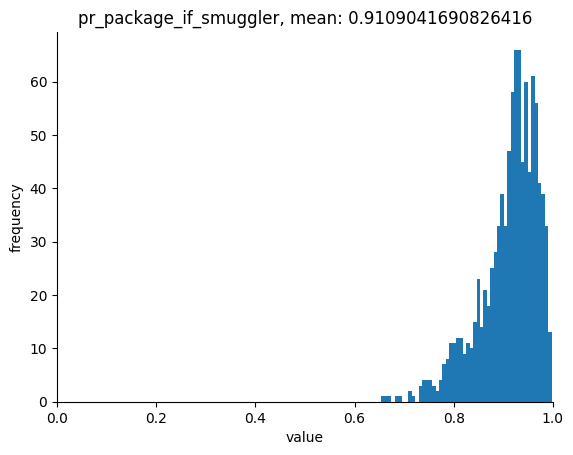

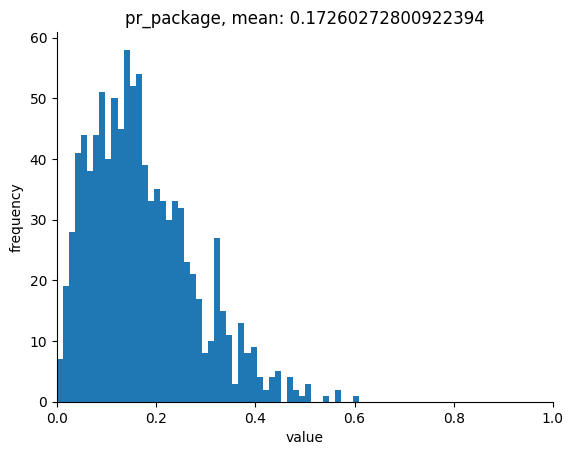

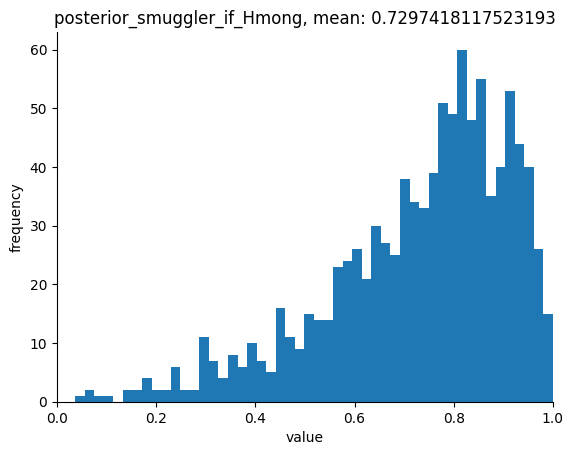

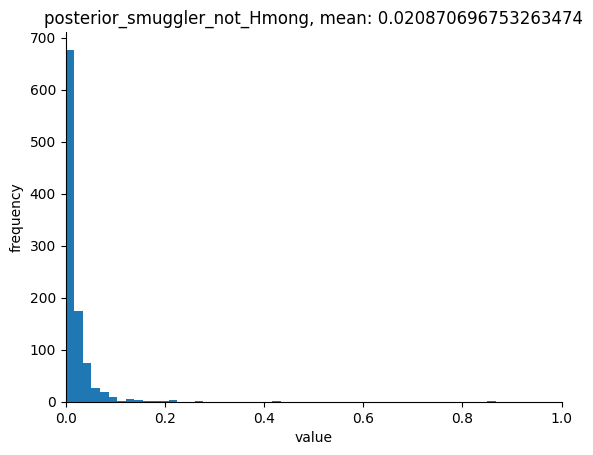

In [6]:
nodes = tr.trace.nodes

for key in nodes.keys():
    if key.startswith("pr") or key.startswith("posterior"):
        plot_site(nodes, key)

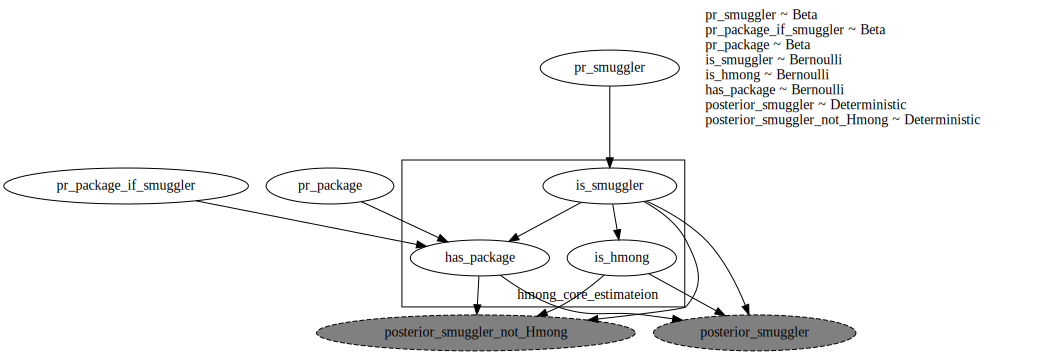

In [27]:
pyro.render_model(hmong_bayesian, render_deterministic=True, render_distributions=True)

In [32]:
prior = nodes["pr_smuggler"]["value"]
posterior_if_Hmong = nodes["posterior_smuggler_if_Hmong"]["value"]
posterior_if_Not_Hmong = nodes["posterior_smuggler_not_Hmong"]["value"]


weight_prior = weight(prior)
weight_posterior_if_Hmong = weight(posterior_if_Hmong)
weight_posterior_if_not_Hmong = weight(posterior_if_Not_Hmong)

print(f"Weight of the prior: {weight_prior}")
print(f"Weight of the posterior with Hmong: {weight_posterior_if_Hmong}")
print(f"Weight of the posterior no Hmong: {weight_posterior_if_not_Hmong}")

Weight of the prior: 0.13662074263405932
Weight of the posterior with Hmong: 0.12265053422092531
Weight of the posterior no Hmong: 0.3557161270469562
